In [ ]:
###############################################################################
############### Term Project - Dog & Cat Classification #######################
######################### Author - Siyuan Liu #################################
########################### March 2022 ########################################

In [ ]:
#https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

In [ ]:
# Helper libraries
import os 
import numpy as np
import tensorflow as tf
import time
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import re # regular expressions
import scipy
import os # Operation System
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages
import sklearn
import tensorflow as tf
from datetime import datetime
import cv2
import seaborn as sns


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
#from plot_keras_history import plot_history

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)


This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#Load the data

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
train_file = "/content/gdrive/MyDrive/458_AI/A4/train.zip"
with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

test_file = "/content/gdrive/MyDrive/458_AI/A4/test.zip"
with zipfile.ZipFile(test_file, 'r') as z:
    z.extractall()

z.close()

In [ ]:
base_dir = "/content"
train_dir = os.path.join(base_dir, 'train')
train_img_names = os.listdir(train_dir)

test_dir = os.path.join(base_dir, 'test') 
test_img_names = os.listdir(test_dir)

In [ ]:
train_img_names[:10]

['cat.11189.jpg',
 'dog.7407.jpg',
 'cat.6572.jpg',
 'dog.6937.jpg',
 'cat.8311.jpg',
 'cat.6513.jpg',
 'cat.4541.jpg',
 'dog.7517.jpg',
 'cat.3881.jpg',
 'cat.8874.jpg']

In [ ]:
test_img_names[:10]

['11155.jpg',
 '32.jpg',
 '12166.jpg',
 '5296.jpg',
 '9651.jpg',
 '232.jpg',
 '9484.jpg',
 '3464.jpg',
 '10588.jpg',
 '1042.jpg']

In [ ]:
print('total train images :', len(train_img_names ))
print('total test images :', len(test_img_names ))

total train images : 25000
total test images : 12500


In [ ]:
# Sorting of file names facilitated by
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
# Generate list of file names, excluding hidden files    
def directory_list (dir_name):
    start_list = os.listdir(dir_name)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file) 
    end_list.sort(key = alphanum_key)        
    return(end_list)    

train_ls = directory_list(train_dir)
len(train_ls)
test_ls = directory_list(test_dir)
len(test_ls)

12500

In [ ]:
#split the file name and extract label data
labels = []
for image in train_img_names:
    label = image.split(".")[0]
    if label == "dog":
        labels.append("dog")
    else:
        labels.append("cat")
df_train = pd.DataFrame({"Image":train_img_names, "label": labels})

In [ ]:
df_train.head()

,Image,label
0,cat.11189.jpg,cat
1,dog.7407.jpg,dog
2,cat.6572.jpg,cat
3,dog.6937.jpg,dog
4,cat.8311.jpg,cat


#EDA

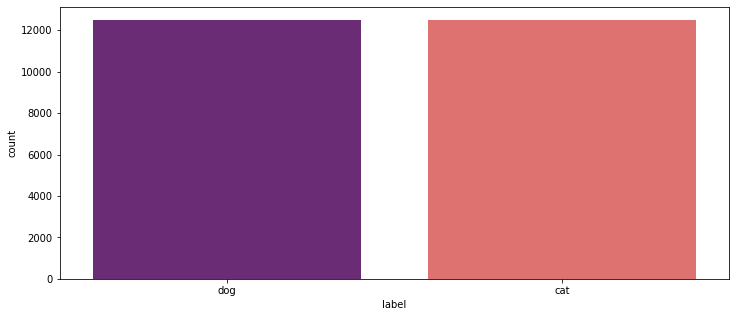

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=df_train, x="label",palette="magma") 

In [ ]:
print(df_train['label'].value_counts())

cat    12500
dog    12500
Name: label, dtype: int64


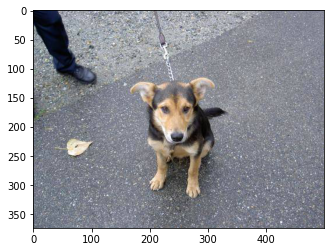

In [ ]:
import random
ran_spl = random.choice(train_img_names)
plt.imshow(plt.imread(("/content/train/"+ran_spl)))

In [ ]:
#image processing functions
def parse_grayscale(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    return(image)
    
def parse_color(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return(image)
  
def parse_grayscale_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    return(image)

def parse_color_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    return(image)  
    
def show_grayscale_image(image):
    plt.imshow(image, cmap = 'gray') 
    plt.axis('off')
    plt.show()

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
import errno
outdir = '/content/cats_dogs_arrays'
try:
    os.makedirs(outdir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [ ]:
# Create Numpy Image Arrays
#----------------------------------------------------------------------
print('\nProcessing image files to 64x64 color or grayscale arrays')
# Create train_128_128_3, test_128_128_3 and numpy array for 3000/ 12500 images in color
train_64_64_3 = np.zeros((25000, 64, 64, 3))  
for ifile in range(len(train_ls)):
    image_file_path = os.path.join(train_dir, train_ls[ifile])
    image = parse_color_and_resize(image_file_path, size = (64,64))
    train_128_128_3[ifile,:,:,:] = image    

test_64_64_3 = np.zeros((12500, 64, 64, 3))  
for ifile in range(len(test_ls)):
    image_file_path = os.path.join(test_dir, test_ls[ifile])
    image = parse_color_and_resize(image_file_path, size = (64,64))
    test_128_128_3[ifile,:,:,:] = image    
    
train_64_64_1 = np.zeros((25000, 64, 64, 1))  
for ifile in range(len(train_ls)):
    image_file_path = os.path.join(train_dir, train_ls[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64,64))
    train_128_128_1[ifile,:,:,0] = image
    
test_64_64_1 = np.zeros((12500, 64,64, 1))  
for ifile in range(len(test_ls)):
    image_file_path = os.path.join(test_dir, test_ls[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64,64))
    test_128_128_1[ifile,:,:,0] = image
    
# Save numpy array objects for analysis       
np.save(os.path.join(outdir, 'train_64_64_3.npy'), train_64_64_3)
np.save(os.path.join(outdir, 'train_64_64_1.npy'), train_64_64_1)
np.save(os.path.join(outdir, 'test_64_64_3.npy'), test_64_64_3)
np.save(os.path.join(outdir, 'test_64_64_1.npy'), test_64_64_1)



Processing image files to 64x64 color or grayscale arrays


In [ ]:
64,64

In [ ]:
# Global Functions & variables
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
random_seed=9999
from tensorflow.python.framework import ops


#Reset Graphs for Tensorboard
def reset_graph(seed= random_seed):
    ops.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    
#Save images to working directory
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(work_dir, "images", chp_id, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    

#Randomly Sort Batches
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        

from matplotlib import pyplot as plt  # for display of images
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    
#Check distribtion of test , valid and train
def dist_plot(var1, var2, var3):
    tmp_plt=sns.countplot(var1, palette="Blues").set_title(var2)
    tmp_fig = tmp_plt.get_figure()
    tmp_fig.savefig(var3 + ".png", 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)
    return(tmp_plt)

Instructions for updating:
non-resource variables are not supported in the long term


#Data Preprocessing & Preparation

In [ ]:
train_64_64_3 = np.load(base_dir + '/cats_dogs_arrays/train_64_64_3.npy')
test_64_64_3 = np.load(base_dir + '/cats_dogs_arrays/test_64_64_3.npy')

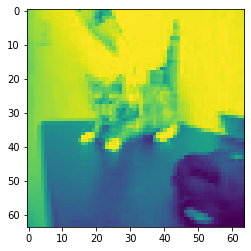

In [ ]:
plt.imshow(train_64_64_3[0,:,:,0])

In [ ]:
#normalize the data

X_train = train_64_64_3
X_test = test_64_64_3

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

x_mean = X_train.mean(axis=0, keepdims=True)
x_std = X_train.std(axis=0, keepdims=True) + 1e-7
x_train_scale = (X_train - x_mean) / x_std
x_test_scale = (X_test - x_mean) / x_std

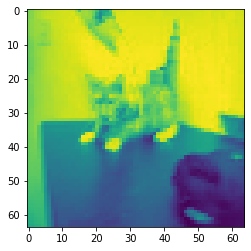

In [ ]:
plt.imshow(x_train_scale[0,:,:,0])

In [ ]:
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
df_train['label_n'] = np.where(df_train['label']=='cat', 0, 1)

y_train = df_train['label_n'].to_numpy()
y_train


array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
##create validation Dataset

x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train_scale
                                                                              ,y_train
                                                                              ,test_size=.2
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [ ]:
print(np.unique(y_train_split, return_counts=True))
print(np.unique(y_valid_split, return_counts=True))

(array([0, 1]), array([10003,  9997]))
(array([0, 1]), array([2497, 2503]))


In [ ]:
print(x_train_split.shape)
print(x_valid_split.shape)
print(x_test_scale.shape)

(20000, 64, 64, 3)
(5000, 64, 64, 3)
(12500, 64, 64, 3)


In [ ]:
# define function for turning softmax result to class category
def class_output(result):
  pred_list = []
  for i in range(len(result)):
    pred = np.argmax(result[i])
    pred_list.append(pred)
  return np.array(pred_list).reshape((len(result), 1))

In [ ]:
##initiate list to track performance for each model


train_accuracy = []
val_accuracy = []
test_accuracy = []
recall = []
f1 = []
precision = []
train_time = []

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [ ]:
# define evaluation metrics tracking function

def score_track(model, x_train, y_train, x_val, y_val):
  result_dic = {}

  pred_trn = class_output(model.predict(x_train))
  ac_trn = accuracy_score(y_train, pred_trn)
  result_dic['accuracy_train'] = ac_trn

  pred_val = class_output(model.predict(x_val))
  ac_val = accuracy_score(y_val, pred_val)
  result_dic['accuracy_valid'] = ac_val
  f1_val = f1_score(y_val, pred_val, average = 'macro')
  result_dic['f1_val'] = f1_val
  recall_val = recall_score(y_val, pred_val, average = 'macro')
  result_dic['recall_val'] = recall_val
  precision_val = precision_score(y_val, pred_val, average = 'macro')
  result_dic['precision_val'] = precision_val

  #there is no test label dataset, since it is for competition

  return result_dic

#Experiment 1 - DNN with 3 layers (with no regularization)

---



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
#reshape the image for DNN training
width = 64
height = 64
channel = 3

x_train_flat = np.reshape(x_train_split, (20000, width*height*channel))
x_valid_flat = np.reshape(x_valid_split, (5000, width*height*channel))
x_test_flat = np.reshape(x_test_scale, (12500, width*height*channel))

In [ ]:
print(x_train_flat.shape, x_valid_flat.shape, x_test_flat.shape)

(20000, 12288) (5000, 12288) (12500, 12288)


In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Dense(input_shape = [width*height*channel], units=384, activation=tf.nn.relu))
model_1.add(layers.Dense(input_shape = [64*32], units=256, activation=tf.nn.relu))  #64*64 for the first hidden layer
model_1.add(layers.Dense(name = 'output_layer', units=2, activation=tf.nn.softmax))

In [ ]:
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 384)               4718976   
                                                                 
 dense_16 (Dense)            (None, 256)               98560     
                                                                 
 output_layer (Dense)        (None, 2)                 514       
                                                                 
Total params: 4,818,050
Trainable params: 4,818,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #set from_logits = False since Softmax has been applied in output layer
              metrics=['accuracy'])

In [ ]:
path = "/content/gdrive/MyDrive/458_AI/A4/"

In [ ]:
start_time = time.time()

history_1 = model_1.fit(
    x_train_flat,
    y_train_split,
    batch_size = 512,
    epochs = 100, 
    validation_data=(x_valid_flat, y_valid_split),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)]
)

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 1s 45us/sample - loss: 1.7603 - acc: 0.4997 - val_loss: 1.2699 - val_acc: 0.4942
Epoch 2/100
20000/20000 [==============================] - 1s 37us/sample - loss: 0.9528 - acc: 0.5520 - val_loss: 1.1584 - val_acc: 0.4992
Epoch 3/100
20000/20000 [==============================] - 1s 37us/sample - loss: 0.7563 - acc: 0.6154 - val_loss: 0.9931 - val_acc: 0.5022
Epoch 4/100
20000/20000 [==============================] - 1s 36us/sample - loss: 0.6601 - acc: 0.6636 - val_loss: 0.9705 - val_acc: 0.4988
Epoch 5/100
20000/20000 [==============================] - 1s 36us/sample - loss: 0.5865 - acc: 0.7110 - val_loss: 0.9848 - val_acc: 0.4938
Epoch 6/100
20000/20000 [==============================] - 1s 35us/sample - loss: 0.5048 - acc: 0.7585 - val_loss: 0.9872 - val_acc: 0.5016


In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
model_1_score = score_track(model_1, x_train_flat, y_train_split, x_valid_flat, y_valid_split)

In [ ]:
model_1_score

{'accuracy_train': 0.99975,
 'accuracy_valid': 0.4946,
 'f1_val': 0.4943507958462248,
 'precision_val': 0.49456393499805074,
 'recall_val': 0.49457407218666394}

In [ ]:
model_1_score['train_time'] = train_time

In [ ]:
preds_1 = model_1.predict(x_test_flat)
print('shape of preds: ', preds_1.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_1.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
7,0.004,1.0,2.702,0.495
8,0.004,1.0,2.718,0.497
9,0.004,1.0,2.732,0.497
10,0.003,1.0,2.743,0.495
11,0.004,1.0,2.763,0.495


In [ ]:
losses = history_1.history['loss']
accs = history_1.history['acc']
val_losses = history_1.history['val_loss']
val_accs = history_1.history['val_acc']
epochs = len(losses)

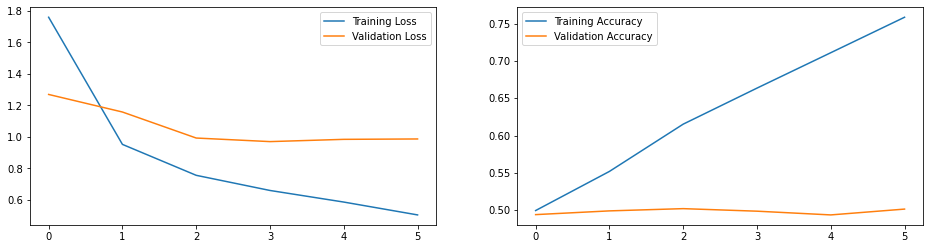

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred1_val= model_1.predict(x_valid_flat)
pred1_val=np.argmax(pred1_val, axis=1)

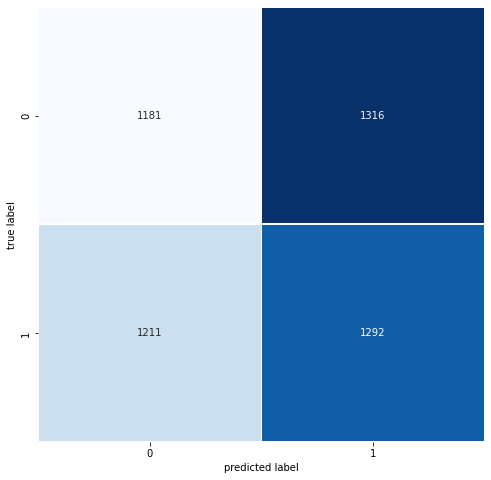

In [ ]:
plot_confusion_matrix(y_valid_split,pred1_val)

Findings:
significant overfitting has been identified from the training process, need to add more regularization to reduce overfitting

#Experiment 2 - DNN with 3 layers

Need to reduce overfitting

*   with L2 regularization
*   add dropout layer



In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Dense(input_shape = [width*height*channel], units=384, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(input_shape = [64*32], units=256, activation=tf.nn.relu))  #64*64 for the first hidden layer
model_2.add(layers.Dense(name = 'output_layer', units=2, activation=tf.nn.softmax))

In [ ]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 384)               4718976   
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               98560     
                                                                 
 output_layer (Dense)        (None, 2)                 514       
                                                                 
Total params: 4,818,050
Trainable params: 4,818,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #set from_logits = False since Softmax has been applied in output layer
              metrics=['accuracy'])

In [ ]:
path = "/content/gdrive/MyDrive/458_AI/A4/"

In [ ]:
start_time = time.time()

history_2 = model_2.fit(
    x_train_flat,
    y_train_split,
    batch_size = 512,
    epochs = 100, 
    validation_data=(x_valid_flat, y_valid_split),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)]
)

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 1s 52us/sample - loss: 2.5054 - acc: 0.4994 - val_loss: 1.8146 - val_acc: 0.4978
Epoch 2/100
20000/20000 [==============================] - 1s 43us/sample - loss: 1.8125 - acc: 0.5177 - val_loss: 1.5594 - val_acc: 0.5044
Epoch 3/100
20000/20000 [==============================] - 1s 43us/sample - loss: 1.5569 - acc: 0.5293 - val_loss: 1.4238 - val_acc: 0.5030
Epoch 4/100
20000/20000 [==============================] - 1s 42us/sample - loss: 1.3923 - acc: 0.5399 - val_loss: 1.3171 - val_acc: 0.4992
Epoch 5/100
20000/20000 [==============================] - 1s 43us/sample - loss: 1.2586 - acc: 0.5532 - val_loss: 1.2447 - val_acc: 0.5056
Epoch 6/100
20000/20000 [==============================] - 1s 44us/sample - loss: 1.1513 - acc: 0.5696 - val_loss: 1.1254 - val_acc: 0.4990
Epoch 7/100
20000/20000 [==============================] - 1s 42us/sample - loss: 1.0652 - acc: 0.5748 - val_lo

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
model_2_score = score_track(model_2, x_train_flat, y_train_split, x_valid_flat, y_valid_split)

In [ ]:
model_2_score

{'accuracy_train': 0.6144,
 'accuracy_valid': 0.4926,
 'f1_val': 0.44551662049177365,
 'precision_val': 0.48930167055167056,
 'recall_val': 0.49295038984856143}

In [ ]:
model_2_score['train_time'] = train_time

In [ ]:
preds_2 = model_2.predict(x_test_flat)
print('shape of preds: ', preds_2.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_2.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
3,1.392,0.540,1.317,0.499
4,1.259,0.553,1.245,0.506
5,1.151,0.570,1.125,0.499
6,1.065,0.575,1.080,0.501
7,0.994,0.590,1.064,0.493


In [ ]:
losses = history_2.history['loss']
accs = history_2.history['acc']
val_losses = history_2.history['val_loss']
val_accs = history_2.history['val_acc']
epochs = len(losses)

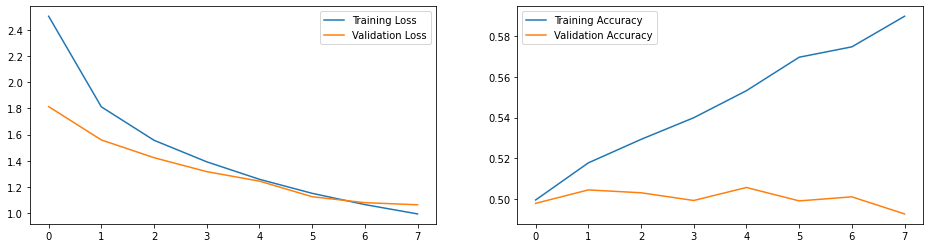

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred2_val= model_2.predict(x_valid_flat)
pred2_val=np.argmax(pred2_val, axis=1)

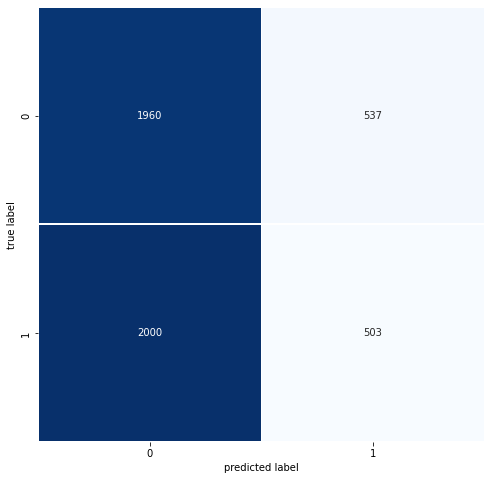

In [ ]:
plot_confusion_matrix(y_valid_split,pred2_val)

#Experiment 3 - CNN with 3 layers (no regularization)


1. 3 Conv Layer + Pooling Layers
2. no regularization
3. Without Dropout & Batch_Normalization layer


In [ ]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(64, 64, 3)))
model_3.add(layers.MaxPool2D((2, 2),strides=2))
model_3.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_3.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_3.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_3.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(units=384, activation=tf.nn.relu))
model_3.add(layers.Dense(units=2, activation=tf.nn.softmax))

In [ ]:
model_3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 256)       295168    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 512)       1180160   
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 512)      

In [ ]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:

start_time = time.time()

history_3 = model_3.fit(x_train_split
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=512
                    ,validation_data=(x_valid_split, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 6s 312us/sample - loss: 0.6929 - acc: 0.5112 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2/100
20000/20000 [==============================] - 6s 310us/sample - loss: 0.6929 - acc: 0.5113 - val_loss: 0.6932 - val_acc: 0.5038
Epoch 3/100
20000/20000 [==============================] - 6s 310us/sample - loss: 0.6926 - acc: 0.5159 - val_loss: 0.6929 - val_acc: 0.5128
Epoch 4/100
20000/20000 [==============================] - 6s 310us/sample - loss: 0.6925 - acc: 0.5170 - val_loss: 0.6931 - val_acc: 0.5042
Epoch 5/100
20000/20000 [==============================] - 6s 310us/sample - loss: 0.6926 - acc: 0.5149 - val_loss: 0.6931 - val_acc: 0.5086
Epoch 6/100
20000/20000 [==============================] - 6s 310us/sample - loss: 0.6908 - acc: 0.5243 - val_loss: 0.7103 - val_acc: 0.4994
Epoch 7/100
20000/20000 [==============================] - 6s 310us/sample - loss: 0.6906 - acc: 0.5268 -

In [ ]:
train_time = end_time - start_time

In [ ]:
model_3_score = score_track(model_3, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [ ]:
model_3_score

{'accuracy_train': 0.55935,
 'accuracy_valid': 0.5088,
 'f1_val': 0.5084574144795957,
 'precision_val': 0.5088582306004309,
 'recall_val': 0.5088324127186743}

In [ ]:
model_3_score['train_time'] = train_time

In [ ]:
preds_3 = model_3.predict(x_test_scale)
print('shape of preds: ', preds_3.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_3.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
3,0.692,0.517,0.693,0.504
4,0.693,0.515,0.693,0.509
5,0.691,0.524,0.710,0.499
6,0.691,0.527,0.696,0.494
7,0.688,0.542,0.698,0.509


In [ ]:
losses = history_3.history['loss']
accs = history_3.history['acc']
val_losses = history_3.history['val_loss']
val_accs = history_3.history['val_acc']
epochs = len(losses)

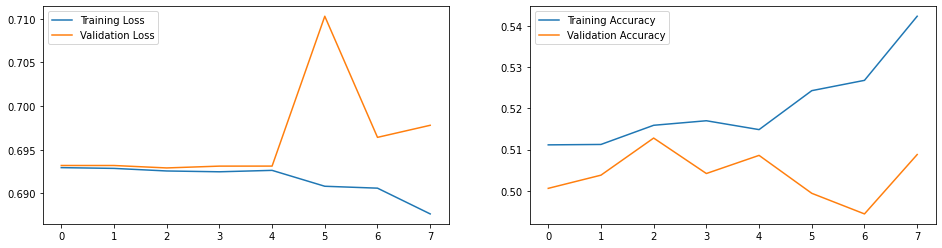

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred3_val= model_3.predict(x_valid_split)
pred3_val=np.argmax(pred3_val, axis=1)

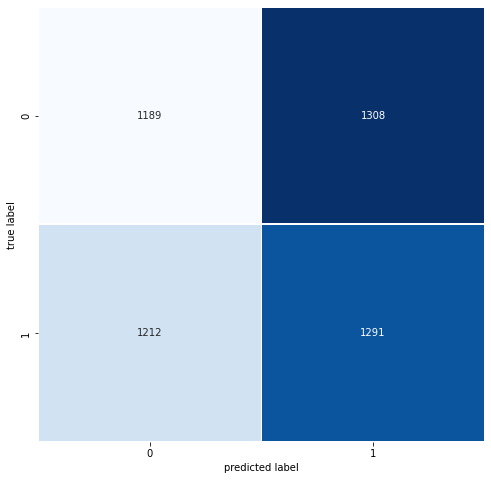

In [ ]:
plot_confusion_matrix(y_valid_split,pred1_val)

In [ ]:
print(x_train_split.shape)
print(x_valid_split.shape)
print(x_test_scale.shape)